<a href="https://colab.research.google.com/github/Brymer-Meneses/PyTorch-Basics/blob/master/DCGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Running on {device}')

Running on cuda


In [4]:
batch_size = 64

train_data = torchvision.datasets.MNIST('./data', train =True, download = True, transform= transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, shuffle =True, batch_size = batch_size)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
dataiter = iter(train_loader)
imgs, labels = next(dataiter)

In [6]:
def imshow(imgs):
  imgs = make_grid(imgs)
  npimgs = imgs.numpy()
  disp = np.transpose(npimgs, (1,2,0))
  
  plt.figure(figsize=(8,8))
  plt.imshow(disp, cmap = 'Greys_r')
  plt.axis("off")
  plt.title('Training Images')
  plt.show()

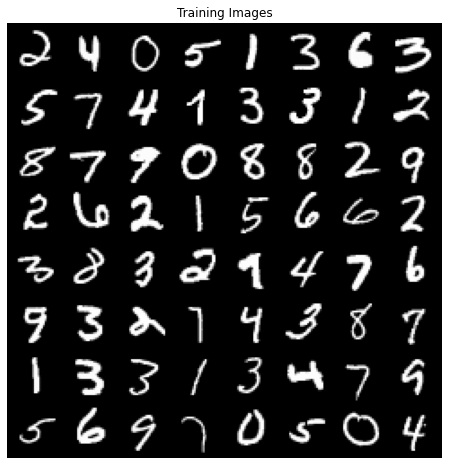

In [7]:
imshow(imgs)

In [8]:
# Generator Hyperparameters
image_size = 28 # (28 x 28)

input_size = 100
feature_map_size = 28
out_channels = 1
real_size = imgs.view(imgs.size(0), -1).size(1)

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class Generator(nn.Module): 
  def __init__(self, input_size, feature_map_size, out_channels):
    super().__init__()

    self.generate = nn.Sequential(
        nn.ConvTranspose2d(in_channels= input_size, 
                           out_channels = feature_map_size*8,
                           kernel_size = 4,
                           stride = 1,
                           padding = 0,
                           bias = False),  # Bias = False, since we use Batch Normalization
        nn.BatchNorm2d(feature_map_size*8),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(in_channels= feature_map_size*8, 
                           out_channels = feature_map_size*4,
                           kernel_size = 4,
                           stride = 2,
                           padding = 1,
                           bias = False), 
        nn.BatchNorm2d(feature_map_size*4),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(in_channels= feature_map_size*4, 
                           out_channels = feature_map_size*2,
                           kernel_size = 4,
                           stride = 2,
                           padding = 1,
                           bias = False), 
        nn.BatchNorm2d(feature_map_size*2),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(in_channels= feature_map_size*2, 
                           out_channels = feature_map_size,
                           kernel_size = 4,
                           stride = 2,
                           padding = 1,
                           bias = False),  
        nn.BatchNorm2d(feature_map_size),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(in_channels= feature_map_size, 
                           out_channels = out_channels,
                           kernel_size = 4,
                           stride = 2,
                           padding = 1,
                           bias = False),  
        nn.Tanh()
    )

  def forward(self, input):
    return self.generate(input)

In [11]:
class Discriminator(nn.Module):
  def __init__(self, input_size, feature_map_size, out_channels):
    super().__init__()

    self.discriminate = nn.Sequential(
        # take the output channel of the generator
        nn.Conv2d(in_channels = out_channels, 
                  out_channels = feature_map_size,
                  kernel_size = 4,
                  stride =2,
                  padding =1, 
                  bias = False),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(in_channels = feature_map_size, 
                  out_channels = feature_map_size*2,
                  kernel_size = 4,
                  stride = 2,
                  padding =1,
                  bias = False),
        nn.BatchNorm2d(feature_map_size*2),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(in_channels = feature_map_size*2, 
                  out_channels = feature_map_size*4,
                  kernel_size = 4,
                  stride = 2,
                  padding =1,
                  bias = False),
        nn.BatchNorm2d(feature_map_size*4),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(in_channels = feature_map_size*4, 
                  out_channels = feature_map_size*8,
                  kernel_size = 4,
                  stride = 2,
                  padding =1,
                  bias = False),
        nn.BatchNorm2d(feature_map_size*8),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(in_channels = feature_map_size*8,
                  out_channels = 1, 
                  stride = 4,
                  kernel_size = 1,
                  padding = 0,
                  bias = False),

        nn.Sigmoid(),
    )
  def forward(self, input):
    return self.discriminate(input)

In [40]:
netD = Discriminator(input_size, feature_map_size, out_channels).to(device)
netG = Generator(input_size, feature_map_size, out_channels).to(device)

In [41]:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (discriminate): Sequential(
    (0): Conv2d(1, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(28, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(56, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(112, 224, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(224, 1, kernel_size=(1, 1), stride=(4, 4), bias=False)
    (12): Sigmoid()
  )
)

In [43]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(image_size, input_size, 1,1, device = device)

real_label = 0.9
fake_label = 0.1


lr = 2e-4
beta1 = 0.5
beta2 = 0.999
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, beta2))

In [44]:
# training loop

n_epochs = 10

img_list = []
G_losses = []
D_losses = []
iters = 0 

print("Starting training loop...")
print(f"Running on {device}")

for epoch in range(n_epochs):
  for i, data in enumerate(train_loader, 0):

    # Setup
    real_images = data[0].to(device)
    batch_size = real_images.size(0)
    real_label_vector = torch.full((batch_size, ), real_label, dtype = torch.float, device = device) # Vector filled with 1 length 64
    fake_label_vector = torch.full((batch_size, ), fake_label, dtype = torch.float, device = device) # Vector filled with 0 length 64

    #######################################
    #### Training of the Discriminator ####
    ######################################

    # Forward Propagation of Real Images
    netD.zero_grad()
    real_output = netD(real_images).view(-1) # Flattens the matrix
    
    errD_real = criterion(real_output, real_label_vector)

    D_x = real_output.mean().item()

    # Forward Propagation of Fake Images
    noise = torch.randn(batch_size, input_size, 1, 1, device=device)
    # Generate Fake Image
    fake_image = netG(noise)
    # Feed the fake image to the discriminator
    fake_output = netD(fake_image.detach()).view(-1)

    errD_fake = criterion(fake_output, fake_label_vector)

    D_G_z1 = fake_output.mean().item()
    errD = errD_real + errD_fake

    errD.backward()
    optimizerD.step()

    #################################
    ### Training of the Generator ###
    #################################

    netG.zero_grad()
 
    # Since we updated D, we will perform another forward propagation to netD

    fake_output = netD(fake_image).view(-1)
    
    errG = criterion(fake_output, real_label_vector) # netG must see fake_image as "real"

    errG.backward()
    
    D_G_z2 = fake_output.mean().item()
    optimizerG.step()

    G_losses.append(errG.item())
    D_losses.append(errD.item())


    if i % 200 == 0:

      print(f'[{epoch + 1}/{n_epochs}]-[{i}/{len(train_loader)}] Loss_D: {round(errD.item(),4)}, Loss_G: {round(errG.item(),4)}, D(G(z)): {round(D_G_z1,4)}/{round(D_G_z2,4)}')

    if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(train_loader)-1)):
      with torch.no_grad():
          fake = netG(fixed_noise).detach().cpu()
      img_list.append(make_grid(fake, padding=2, normalize=True))

      iters += 1



Starting training loop...
Running on cuda
[1/10]-[0/938] Loss_D: 1.4221, Loss_G: 0.9573, D(G(z)): 0.5005/0.3643
[1/10]-[200/938] Loss_D: 0.659, Loss_G: 2.1227, D(G(z)): 0.1062/0.0956
[1/10]-[400/938] Loss_D: 0.6509, Loss_G: 2.1126, D(G(z)): 0.1012/0.0967
[1/10]-[600/938] Loss_D: 0.6509, Loss_G: 2.0756, D(G(z)): 0.1015/0.1009
[1/10]-[800/938] Loss_D: 0.6508, Loss_G: 2.1171, D(G(z)): 0.1041/0.0962
[2/10]-[0/938] Loss_D: 0.6506, Loss_G: 2.0749, D(G(z)): 0.1/0.1009
[2/10]-[200/938] Loss_D: 0.6505, Loss_G: 2.0896, D(G(z)): 0.1016/0.0993
[2/10]-[400/938] Loss_D: 0.6507, Loss_G: 2.1418, D(G(z)): 0.104/0.0936
[2/10]-[600/938] Loss_D: 0.6507, Loss_G: 2.096, D(G(z)): 0.105/0.0985
[2/10]-[800/938] Loss_D: 0.6506, Loss_G: 2.1185, D(G(z)): 0.1047/0.0961
[3/10]-[0/938] Loss_D: 0.6507, Loss_G: 2.1066, D(G(z)): 0.0998/0.0974
[3/10]-[200/938] Loss_D: 0.6505, Loss_G: 2.0893, D(G(z)): 0.1003/0.0993
[3/10]-[400/938] Loss_D: 0.6506, Loss_G: 2.0876, D(G(z)): 0.0999/0.0995
[3/10]-[600/938] Loss_D: 0.6505, Lo

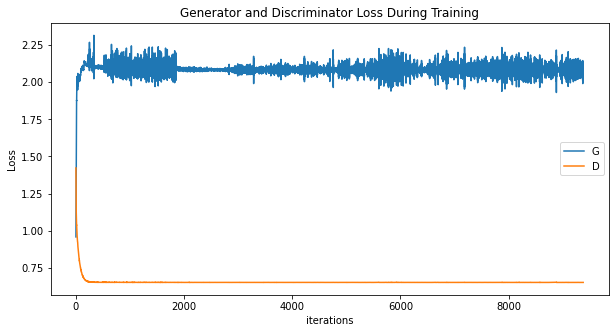

In [45]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

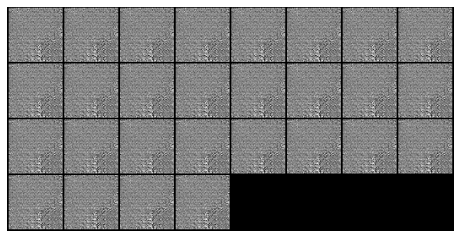

In [46]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
print("Hello %.3f" %(5))

Hello 5.000
